# Value at Risk (VaR)

The purpose of this notebook is to create a concise overview of calculating VaR.

Value at Risk (VaR) is the maximum loss which should not be exceeded during a specific time period with a given probability level.

It is determined by 3 variables: period, confidence level, and the size of the possible loss.

Some methods for calculating VaR include:
* Historical method
* Variance-covariance method
* Monte Carlo Simulation



### Historical Method

Use historical market data to estimate potential losses.  It is straightforward and widely used because it does not require assumptions about the distribution of asset returns. The process is as follows:

* Collect historical data: Gather historical prices or returns for the assets in the portfolio over a chosen time frame.

* Calculate portfolio returns: Compute the historical returns of the portfolio for each day.

* Sort returns: Arrange the portfolio from worst to best

* Determine VaR: Identify the return at the specified confidence level.

$$VaR = v_{m}\frac{v_{i}}{v_{i-1}} $$, where

* $v_{i}$ is the number of variables on day $i$
* $m$ is the number of days from which historical data is taken.


### Variance-Covariance

Uses the variances and covariances of assets for VaR calculation.

Assumptions:
* Asset returns are normally distributed around the mean.

There are two factors to be estimated:
* An expected return
* A Standard Deviation

This is for parametric purposes only, so the distributions are known and reliably estimated.

We have loss $l$ for portfolio $p$ with $n$ number of instruments:

$$
l_{p} = l_{1} + l_{2} + l_{3} + \ldots + l_{n}
$$

$$
\sigma^{2}_{p} = \sigma^{2}_{1} + \sigma^{2}_{2} + \ldots + \sigma^{2}_{n} + \rho_{1,2,3,\ldots, n} \sigma_{1} + \sigma_{2} \cdots \sigma_{n}
$$ where

* $\sigma_{p}^{2} = $ standard deviation of the loss on the portfolio
* $\sigma^{2}_{1} = $ loss form instrument 1
* $\rho_{1,2,3,\ldots, n} = $ correlation between losses 1 to n

In other words,

$\sigma_{p}^{2} = \bf{w}^{T} \bf{\Sigma} \bf{w}$ where
* $\bf{w}$ is the vector of portfolio weights,
* $\Sigma$ is the covariance matri of asset returns.



In [109]:
!pip install yfinance
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats

from typing import Union # For commenting functions

## One-asset VaR

Here, we will look at only one asset.

In [88]:
# We import historical stock price data for AXON
# AXON is American company based in Scottsdale, Arizona that develops technology
# and weapons products for military, law enforcement, and civilians. Known for body cameras.

# Extract historical stock prices from yahoo finance
hist = yf.download('AXON', start='2023-01-01', end='2024-01-01')
hist.drop(columns=['Open', 'Close', 'High', 'Low', 'Volume'], inplace=True)

[*********************100%***********************]  1 of 1 completed


In [89]:
# View the first 5 rows
hist.head()

Price,Adj Close
Ticker,AXON
Date,
2023-01-03 00:00:00+00:00,168.240005
2023-01-04 00:00:00+00:00,168.759995
2023-01-05 00:00:00+00:00,165.740005
2023-01-06 00:00:00+00:00,170.899994
2023-01-09 00:00:00+00:00,177.449997


In [90]:
hist.columns

MultiIndex([('Adj Close', 'AXON')],
           names=['Price', 'Ticker'])

In [91]:
# Calculate daily percentage returns
hist['Returns'] = hist['Adj Close'].pct_change()

# Flatten the MultiIndex by removing the empty string and renaming columns
hist.columns = hist.columns.droplevel(1)

In [92]:
hist

Price,Adj Close,Returns
Date,,
2023-01-03 00:00:00+00:00,168.240005,NaN
2023-01-04 00:00:00+00:00,168.759995,0.003091
2023-01-05 00:00:00+00:00,165.740005,-0.017895
2023-01-06 00:00:00+00:00,170.899994,0.031133
2023-01-09 00:00:00+00:00,177.449997,0.038327
...,...,...
2023-12-22 00:00:00+00:00,259.029999,0.008527
2023-12-26 00:00:00+00:00,258.109985,-0.003552
2023-12-27 00:00:00+00:00,259.079987,0.003758


In [93]:
# Drop NaNs
hist.dropna(subset=['Returns'], inplace=True)

In [94]:
# 99% Confidence Interval

confidence_interval = 0.99
VaR = -np.percentile(hist['Returns'], 100 - (confidence_interval * 100))
print(VaR)

0.03973342105372049


We expect to lose no more than 3.97% of the value of our position, 99% of the time.

Let's look at the plot.

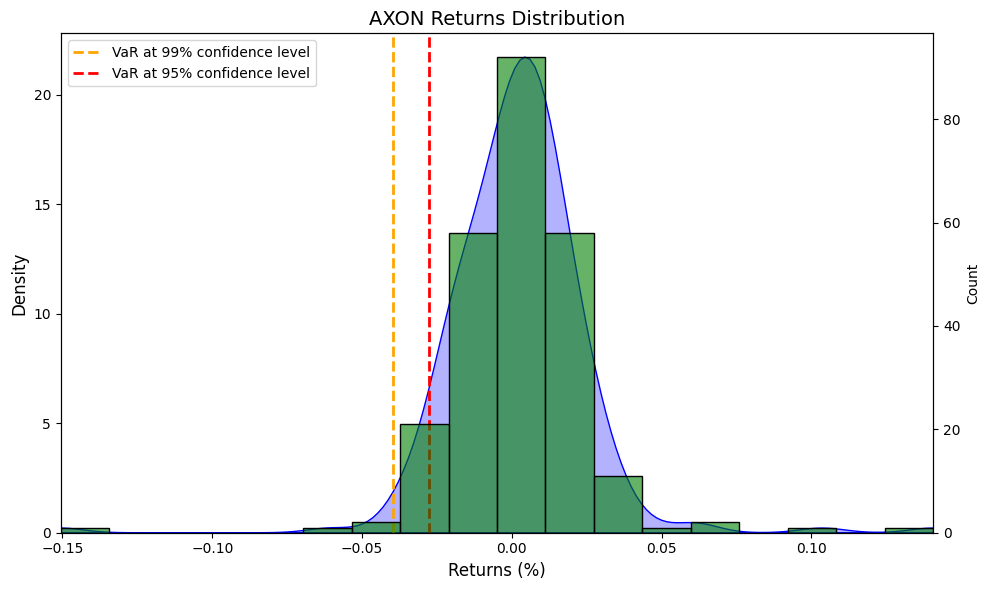

In [95]:
# Create the figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot KDE
sns.kdeplot(data=hist, x="Returns", ax=ax1, color='blue', fill=True, alpha=0.3)
ax1.set_xlim(hist["Returns"].min(), hist["Returns"].max())
ax2 = ax1.twinx()

sns.histplot(data=hist, x="Returns", bins=18, ax=ax2, color='green', alpha=0.6)

# Add vertical lines for VaR at 99% and 95% confidence levels
ax1.axvline(np.percentile(hist['Returns'], 1), color='orange', linestyle='--',
            label="VaR at 99% confidence level", linewidth=2)
ax1.axvline(np.percentile(hist['Returns'], 5), color='red', linestyle='--',
            label="VaR at 95% confidence level", linewidth=2)
ax1.legend(loc='upper left')

ax1.set_title('AXON Returns Distribution', fontsize=14)
ax1.set_xlabel('Returns (%)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

The orange line (VaR at 99%) suggests that, with high confidence (99%), the stock will not experience a return worse than this level. If the returns go beyond this line, it would signify an extreme loss, but this is expected to happen only 1% of the time.

The red line (VaR at 95%) indicates a more moderate confidence level (95%), and losses beyond this point are more frequent than those beyond the 99% VaR threshold.

### Multi-Asset

Now let's consider the case when our portfolio has multiple assets.
We assume an equally weighted portfolio.

In [96]:
# Let's add more assets

tickers = ['AXON','AAPL', 'MSFT', 'CRWD', 'PHO']
# Create dataframe and consider the Adj Close for calculating our returns
df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start='2023-01-01', end='2024-01-01')
    df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [98]:
# Get the first 5 rows
df.head()

,AXON,AAPL,MSFT,CRWD,PHO
Date,,,,,
2023-01-03 00:00:00+00:00,168.240005,123.768456,235.711716,103.279999,51.037262
2023-01-04 00:00:00+00:00,168.759995,125.045036,225.400925,104.364998,51.770187
2023-01-05 00:00:00+00:00,165.740005,123.718979,218.720551,94.889999,50.958035
2023-01-06 00:00:00+00:00,170.899994,128.271103,221.298233,94.720001,51.908852
2023-01-09 00:00:00+00:00,177.449997,128.795578,223.452866,96.570000,51.997986


In [99]:
# Calculate the returns for each asset
returns = df.pct_change()
returns = returns.dropna()
returns

,AXON,AAPL,MSFT,CRWD,PHO
Date,,,,,
2023-01-04 00:00:00+00:00,0.003091,0.010314,-0.043743,0.010505,0.014361
2023-01-05 00:00:00+00:00,-0.017895,-0.010605,-0.029638,-0.090787,-0.015688
2023-01-06 00:00:00+00:00,0.031133,0.036794,0.011785,-0.001792,0.018659
2023-01-09 00:00:00+00:00,0.038327,0.004089,0.009736,0.019531,0.001717
2023-01-10 00:00:00+00:00,0.010595,0.004456,0.007617,-0.009320,0.014667
...,...,...,...,...,...
2023-12-22 00:00:00+00:00,0.008527,-0.005547,0.002784,-0.006568,0.005465
2023-12-26 00:00:00+00:00,-0.003552,-0.002841,0.000214,0.008763,0.004942
2023-12-27 00:00:00+00:00,0.003758,0.000518,-0.001575,-0.002133,0.004425


In [101]:
# Now, we will assume an equal weighting of the assets
# WLOG, lets assume the value of our portfolio
portfolio_value = 1000000
# We define weights of each asset (assume equal weight)
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


In [102]:
# calculating the returns
historical_returns = (returns * weights).sum(axis =1)
print(historical_returns)

Date
2023-01-04 00:00:00+00:00   -0.001094
2023-01-05 00:00:00+00:00   -0.032922
2023-01-06 00:00:00+00:00    0.019316
2023-01-09 00:00:00+00:00    0.014680
2023-01-10 00:00:00+00:00    0.005603
                               ...   
2023-12-22 00:00:00+00:00    0.000932
2023-12-26 00:00:00+00:00    0.001505
2023-12-27 00:00:00+00:00    0.000999
2023-12-28 00:00:00+00:00   -0.000342
2023-12-29 00:00:00+00:00   -0.002754
Length: 249, dtype: float64


In [103]:
# Set the rolling window size for the sum of returns over the past 'days' (50 days in this case)
days = 50

# Calculate the rolling sum of returns over the specified window size (50 days).
# This gives the cumulative sum of returns over each window.
cumulative_returns = historical_returns.rolling(window=days).sum()

# Drop any rows with missing values (NaN) that result from the rolling calculation,
# as the first 'days-1' rows will have NaN values due to insufficient data for the rolling window.
cumulative_returns = cumulative_returns.dropna()

# Print the cumulative returns to verify the result
print(cumulative_returns)


Date
2023-03-16 00:00:00+00:00    0.187377
2023-03-17 00:00:00+00:00    0.181650
2023-03-20 00:00:00+00:00    0.215512
2023-03-21 00:00:00+00:00    0.211491
2023-03-22 00:00:00+00:00    0.181397
                               ...   
2023-12-22 00:00:00+00:00    0.170799
2023-12-26 00:00:00+00:00    0.180559
2023-12-27 00:00:00+00:00    0.169960
2023-12-28 00:00:00+00:00    0.168635
2023-12-29 00:00:00+00:00    0.177226
Length: 200, dtype: float64


Let's consider a 99% VaR

In [105]:
# 99%
confidence_interval = 0.99
# Calculate VaR
VaR = -np.percentile(cumulative_returns, 100 - (confidence_interval * 100))*portfolio_value
print(VaR)

39090.931716194114


We expect to lose no more than $39,090.93 of the value of our position, 99% of the time.

Just like before. Let's create a plot.

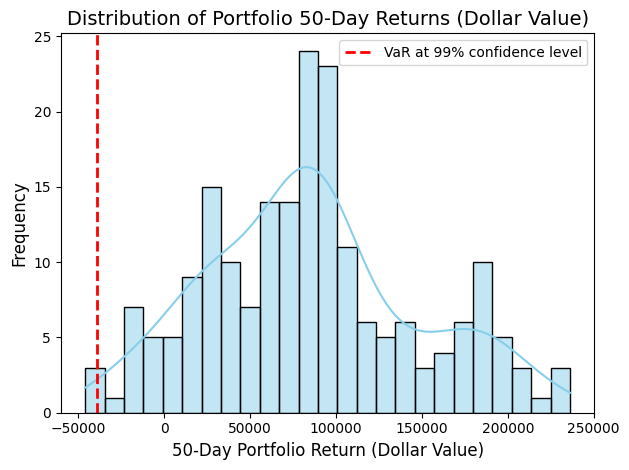

In [106]:
# Define the rolling window size (e.g., 50 days)
return_window = days

# Calculate the rolling sum of returns over the specified window size (e.g., 50 days)
# This represents the cumulative returns for the past 50 days.
cumulative_returns = historical_returns.rolling(window=return_window).sum()
# Drop NaNs
cumulative_returns = cumulative_returns.dropna()

# Convert the cumulative returns to dollar value by multiplying with the portfolio value
cumulative_returns_dollar = cumulative_returns * portfolio_value

sns.histplot(cumulative_returns_dollar, bins=25, kde=True, color='skyblue', edgecolor='black')

# Add a vertical line at the Value at Risk (VaR) for the specified confidence level (e.g., 99% or 95%)
plt.axvline(-VaR, color='red', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')

plt.xlabel(f'{return_window}-Day Portfolio Return (Dollar Value)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)', fontsize=14)

plt.legend()

plt.tight_layout()  # Ensure the plot fits well within the figure area
plt.show()


# VaR Using Monte Carlo

In [108]:
# Get our returns
returns

,AXON,AAPL,MSFT,CRWD,PHO
Date,,,,,
2023-01-04 00:00:00+00:00,0.003091,0.010314,-0.043743,0.010505,0.014361
2023-01-05 00:00:00+00:00,-0.017895,-0.010605,-0.029638,-0.090787,-0.015688
2023-01-06 00:00:00+00:00,0.031133,0.036794,0.011785,-0.001792,0.018659
2023-01-09 00:00:00+00:00,0.038327,0.004089,0.009736,0.019531,0.001717
2023-01-10 00:00:00+00:00,0.010595,0.004456,0.007617,-0.009320,0.014667
...,...,...,...,...,...
2023-12-22 00:00:00+00:00,0.008527,-0.005547,0.002784,-0.006568,0.005465
2023-12-26 00:00:00+00:00,-0.003552,-0.002841,0.000214,0.008763,0.004942
2023-12-27 00:00:00+00:00,0.003758,0.000518,-0.001575,-0.002133,0.004425


In [110]:
def expected_return(weights: np.ndarray, returns: pd.DataFrame) -> float:
  """
  Calculates the expected portfolio return
  """
  return np.sum(returns.mean() * weights)

def standard_deviation(weights: np.ndarray, cov_matrix: np.ndarray) -> float:
  """
  Calculates the standard deviation of the portfolio
  """
  variance = weights.T @ cov_matrix @ weights # Matrix multiplication
  return np.sqrt(variance)

In [111]:
# Get cov_matrix
cov_matrix = returns.cov()
print(cov_matrix)

          AXON      AAPL      MSFT      CRWD       PHO
AXON  0.000520  0.000036  0.000023  0.000139  0.000068
AAPL  0.000036  0.000158  0.000109  0.000141  0.000057
MSFT  0.000023  0.000109  0.000250  0.000182  0.000048
CRWD  0.000139  0.000141  0.000182  0.000689  0.000089
PHO   0.000068  0.000057  0.000048  0.000089  0.000100


### Simulation

Now, we will use Monte Carlo simulation to calculate VaR

In [112]:
# For consistency, we consider the same assumptions

portfolio_value = 1000000
# We define weights of each asset (assume equal weight)
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


In [113]:
portfolio_expected_return = expected_return(weights, returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

print(f"The expected of return is {portfolio_expected_return}")
print(f"The standard deviation of return is {portfolio_std_dev}")

The expected of return is 0.0021037123024431627
The standard deviation of return is 0.011829835891632084


In [114]:
def random_z_score() -> float:
  """
  Returns Z-Score
  """
  return np.random.normal(0,1)


def scenario_gain_loss(portfolio_value: float,
                       portfolio_std_dev: float,
                       z_score: float,
                       days: int) -> float:

    """
    This function calculates the gain or loss of a portfolio over a specified number of days
    based on the portfolio's value, expected return, standard deviation, and a randomly generated z-score.

    :param portfolio_value: The initial value of the portfolio.
    :param portfolio_std_dev: The portfolio's standard deviation (risk).
    :param z_score: The z-score representing the random normal value for the scenario.
    :param days: The number of days for which the scenario is applied.
    :return: The portfolio gain or loss after the specified period.
    """

    # Calculate the scenario gain or loss using the formula for portfolio return and risk
    return (portfolio_value * portfolio_expected_return * days +
            portfolio_value * portfolio_std_dev * z_score * np.sqrt(days))

In [115]:
# Now, we will run our Monte Carlo simulation

simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

Calculate VaR at 99%

In [120]:
# VaR Calculate
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(f'We expect to lose no more than ${VaR.round(2)} of the value of our position, 99% of the time')

We expect to lose no more than $92140.07 of the value of our position, 99% of the time


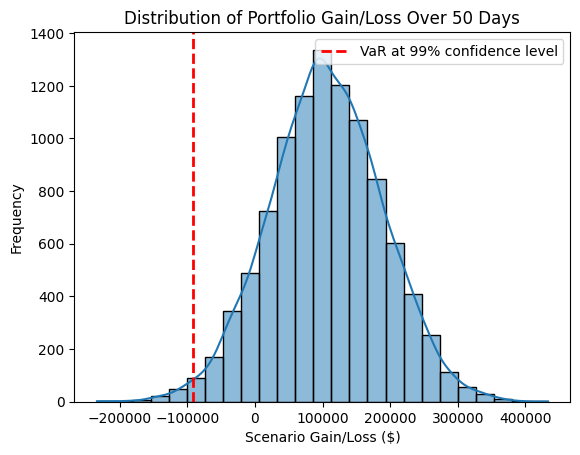

In [119]:
# Plot the results
sns.histplot(scenarioReturn, bins=25, kde=True)

# Set labels and title for the plot
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')

# Add a vertical line at the Value at Risk (VaR) level to indicate the 99% confidence level
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')

plt.legend()

plt.show()

Interestingly, the results show a difference between the historical and Monte Carlo approaches.

Why is that?

Underlying Assumptions: Monte Carlo simulations make assumptions about the distribution of returns (e.g., normal distribution) and volatility, while historical simulations use actual past data. If the market conditions in the past do not reflect future conditions, the results will differ.

Tail Risk Representation: Historical simulations are limited by the available historical data, and if there are no extreme events in the data, the model might underestimate risk. In contrast, Monte Carlo simulations can generate extreme events by adjusting the distribution (such as using fat-tailed distributions).

Sample Size and Period: The results can also depend on the sample size. Historical simulations rely on a finite set of data, which may not capture the full range of possible outcomes. Monte Carlo simulations can generate many more scenarios, providing a more comprehensive view of potential future outcomes, depending on the number of simulations.

Furthermore, we are making a lot of assumptions with the data already, such as short time window and equal weighting of assets.